<a href="https://colab.research.google.com/github/z0rdj/drena/blob/master/Pratical_Assignment_2_ResNetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1**

 In this assignment you are going to learn how to build a CNN model, train it and test it. This is fundamental for your upcoming assignments. This first assignment is for getting started purposes. It will not be required for you to provide a report.

**Contents:**
*   Build a CNN
*   Load and prepare a Dataset
*   Training a model
*   Testing a model

In case of implementation doubts, check the PyTorch documentation (https://pytorch.org/docs/stable/nn.html)












# **Tutorial**
Let's start by importing the torch libray.

In [ ]:
# Library imports
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision.models as models

###**Initializing the network:**
*   Assign the CNN model to the GPU (if available)
*   Check the CNN architecure using torchsummary (important to check if the layers' input and output dimensions are correctly set)


In [ ]:
# Check your built CNN model
cnn_model = models.resnet18(pretrained=True)
#pretrained=True
#cnn_model = nnModel(10)
print(cnn_model.fc.out_features) # 1000 
#print("CNN Architecture: "+ str(cnn_model))



# Freeze training for all layers
#for param in cnn_model.layer.parameters():
 #  param.require_grad = False

lt=9
child_counter=0

child_counter = 0
for child in cnn_model.children():
     #print(" child", child_counter, "is:")
     #print(child)
     if child_counter < lt:
          print(" child", child_counter, "is frozen")
          print(child)
          for param in child.parameters():
               param.requires_grad = False
     child_counter += 1
# Newly created modules have require_grad=True by default
num_features = cnn_model.fc.in_features
features = list(cnn_model.fc.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, 10)]) # Add our layer with 10 outputs
cnn_model.fc = nn.Linear(num_features,10) # Replace the model classifier
print(cnn_model)





device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print('\nThe model will run on', device)
cnn_model = cnn_model.to(device)

# Using the torchsummary, you can check your network in more detail
import torchsummary
print("\n\n")
torchsummary.summary(cnn_model, input_size = (3, 32, 32), batch_size = 5) 



1000
 child 0 is freaze
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
 child 1 is freaze
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 child 2 is freaze
ReLU(inplace=True)
 child 3 is freaze
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
 child 4 is freaze
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(i

## **Dataset**

####**Dataset**
MNIST database - a set ot 70,000 28×28 pixel grayscale images of handwritten digits (a training set with 60,000 examples, and a test set with 10,000 examples)

**Goal:** Classify images of handwritten digits into one of 10 classes representing the values from 0 to 9.



In [ ]:
# Library imports
from torchvision . datasets import CIFAR10
import torchvision . transforms as tt
import numpy as np
#transform = tt . ToTensor () #fazer o resize
transform = tt.Compose([
                                tt.Resize(224),
                                tt.RandomHorizontalFlip(p=0.1),
                                tt.ToTensor(),
                                tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
                                
                                ])
training_data = CIFAR10 ( download = True , root ="./ data ", transform = transform )
testing_data = CIFAR10 ( root ="./ data ", train = False , transform = transform )
from torch.utils.data.sampler import SubsetRandomSampler # Sampler 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./ data /cifar-10-python.tar.gz to ./ data 


In [ ]:
# Download the dataset online available on PyTorch 
# Transform

# [
#   transforms.RandomResizedCrop(32)
#   transforms.Rando
# ]

# transform = transforms.ToTensor()

# training_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
# testing_data  = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Dataset is already divided in training and testing. 
# However, to analize the model over the training step, and also perform cross-validation, the training set must be divided in two parts:
#   Training Set (80%)
#   Validation Set (20%)

# Lets start to obtain training indices
num_train = len(training_data)
print("Number of images in original training set: " + str(num_train)) # 60 000
indices = list(range(num_train))

# Randomly Shuffle
np.random.shuffle(indices)

# Split 80%/20%
split = int(np.floor(num_train * 0.2)) # 12 000
print("Split Number: " + str(split))
training_idx, valid_idx = indices[split:], indices[:split] # 48 000 / 12 000
print("Number of training images: " + str(len(training_idx)))
print("Number of validation images: " + str(len(valid_idx)))

# Lets also see how many images are on testing set
print("Number of images in the testing set: " + str(len(testing_data))) # 10 000

Number of images in original training set: 50000
Split Number: 10000
Number of training images: 40000
Number of validation images: 10000
Number of images in the testing set: 10000


In [ ]:
# To train the network, you must "encode" the data into a PyTorch dataloader
# Since you divided the original training set in 2, now you need to assign the indices to the samples
training_sampler = SubsetRandomSampler(training_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

batch_size = 128 # 16 images per batch

# Training Set
training_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                              batch_size = batch_size, \
                                              sampler = training_sampler)

# Validation Set
valid_loader = torch.utils.data.DataLoader(dataset = training_data, \
                                           batch_size = batch_size, \
                                           sampler = valid_sampler)

# Testing Set
# Here, you do not need the "sampler" input, since you did not change the original testing set
testing_loader = torch.utils.data.DataLoader(dataset = testing_data, \
                                           batch_size = batch_size, \
                                           shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

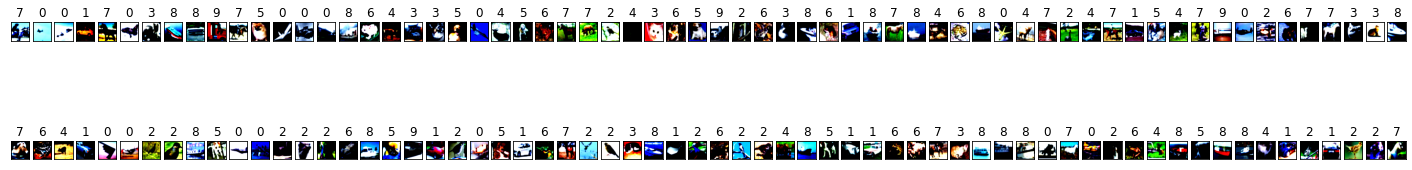

In [ ]:
# Visualization of a whole batch
import matplotlib.pyplot as plt

# Get images
dataiter = iter(training_loader)
images, labels = dataiter.next() # Get the images and their labels

# Plot the whole batch 
fig = plt.figure(figsize=(25, 4))
# Loop over all the images in the batch(16)
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    # Subplot with the image 
    plt.imshow(np.transpose(images[idx],(1,2,0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## **Training**

In [ ]:
# Library imports
import torch.optim as optim

In [ ]:
# To train a CNN, you must choose (or develop) a loss function, an optimizer algorithm, and a set of hyper-parameters (learning rate, number of epochs, etc)
# Hyper-parameters
lr = 0.0001
num_epochs = 30

# Loss Function
criterion = nn.CrossEntropyLoss() # Cross entropy loss function is widely used in classification problems
# Optimizer Algorithm
optimizer = optim.Adam(cnn_model.parameters(), lr = lr)

# Training
running_loss = 0.0

for epoch in range(num_epochs):
  for batch_id, data in enumerate(training_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Pass images through the CNN
    outputs = cnn_model(images)

    # Create a loss value
    loss = criterion(outputs, labels)

    # Backpropagation
    optimizer.zero_grad() # zero the parameter gradients
    loss.backward()
    optimizer.step()

    # Check some statistics
    running_loss += loss.item()
    if batch_id % 1000 == 999: # prints every 1000 batchs
      print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_id + 1, running_loss / 1000))
      running_loss = 0.0
  
  # For each epoch, analize the model performance
  valid_correct = 0
  valid_total = 0
  valid_total_loss = 0
  with torch.no_grad(): # In this part, you will not train, so you don't need to calculate gradients
    for valid_batch_id, valid_data in enumerate(valid_loader, 0):
      valid_images, valid_labels = valid_data
      valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)
      valid_outputs = cnn_model(valid_images)
      valid_loss = criterion(valid_outputs, valid_labels)
      valid_total_loss += valid_loss.item()
      _, valid_predicted = torch.max(valid_outputs.data, 1)
      valid_total += valid_labels.size(0)
      valid_correct += (valid_predicted == valid_labels).sum().item()
  print("(Validation Set) Epoch: " + str(epoch + 1) + " Loss: " + str(valid_total_loss/ len(valid_idx)) + " Acc: " + str(100*valid_correct/valid_total))

print("Training is completed!")


(Validation Set) Epoch: 1 Loss: 0.011477519130706788 Acc: 62.32
(Validation Set) Epoch: 2 Loss: 0.008548370796442032 Acc: 71.57
(Validation Set) Epoch: 3 Loss: 0.007287175458669662 Acc: 73.9
(Validation Set) Epoch: 4 Loss: 0.006572281384468079 Acc: 75.3
(Validation Set) Epoch: 5 Loss: 0.006154307442903519 Acc: 75.73
(Validation Set) Epoch: 6 Loss: 0.005886670517921448 Acc: 76.37
(Validation Set) Epoch: 7 Loss: 0.005649806493520737 Acc: 76.99
(Validation Set) Epoch: 8 Loss: 0.005485518801212311 Acc: 77.45
(Validation Set) Epoch: 9 Loss: 0.00530312106013298 Acc: 77.61
(Validation Set) Epoch: 10 Loss: 0.005244065451622009 Acc: 78.18
(Validation Set) Epoch: 11 Loss: 0.005095081686973571 Acc: 77.96
(Validation Set) Epoch: 12 Loss: 0.005126947763562203 Acc: 78.13
(Validation Set) Epoch: 13 Loss: 0.0050324005484580995 Acc: 78.86
(Validation Set) Epoch: 14 Loss: 0.004977526625990868 Acc: 78.75
(Validation Set) Epoch: 15 Loss: 0.004945254608988762 Acc: 78.68
(Validation Set) Epoch: 16 Loss: 0.0

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'pretrained_frozen'
path = F"/content/gdrive/My Drive/Resnet18/{model_save_name}" 
torch.save(cnn_model.state_dict(), path)

## **Testing**

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate a CNN is similar to the training process without the backpropagation.
# To evaluate a CNN, we need to follow the evaluation metrics
num_classes = 10
correct = 0
total = 0
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
conf_matrix =[[0 for x in range(num_classes)] for y in range(num_classes)]

cnn_model.eval()

with torch.no_grad(): # You are not training, so you don't need to calculate gradients
  for batch_id, data in enumerate(testing_loader, 0):
    # Get the images and their labels
    images, labels = data
    # Send the images and their labels to the training device
    images, labels = images.to(device), labels.to(device)

    # Calculate the CNN's predictions by running images through the network
    outputs = cnn_model(images)

    # The class with the highest
    _, predicted = torch.max(outputs.data, 1)

    # Get model's performance
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    c = (predicted == labels).squeeze()

    for i in range(len(images)):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
    
    conf_matrix+=confusion_matrix(predicted.cpu(), labels.cpu(),labels=[x for x in range( num_classes )])

# Show model's performance
print('Accuracy using {} test images: {} %\n'.format(total,100 * correct / total))
# Performance per Class
for i in range(num_classes):
  if class_total[i] == 0:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 0, 0))
  else:
    print('Accuracy of %2s : %2d %% in %d Images' % (i, 100 * class_correct[i] / class_total[i], class_total[i]))

# Confusion Matrix
print('\nConfusion Matrix')
print(conf_matrix)
 


Accuracy using 10000 test images: 80.46 %

Accuracy of  0 : 81 % in 1000 Images
Accuracy of  1 : 89 % in 1000 Images
Accuracy of  2 : 73 % in 1000 Images
Accuracy of  3 : 68 % in 1000 Images
Accuracy of  4 : 75 % in 1000 Images
Accuracy of  5 : 77 % in 1000 Images
Accuracy of  6 : 85 % in 1000 Images
Accuracy of  7 : 80 % in 1000 Images
Accuracy of  8 : 88 % in 1000 Images
Accuracy of  9 : 86 % in 1000 Images

Confusion Matrix
[[812  14  40  16  12   2   6  17  60  15]
 [ 13 894   2   6   1   2   6   5  26  70]
 [ 35   2 730  38  50  23  36  20   4   1]
 [  9   5  47 683  37 120  35  31   5   9]
 [ 10   2  63  26 751  26  24  52   4   0]
 [  3   2  31 133  26 772  23  43   2   2]
 [  6   3  52  53  45  18 857  11   1   2]
 [ 11   5  16  21  62  31   5 803   3   5]
 [ 79  14  15  13  10   4   6   8 880  32]
 [ 22  59   4  11   6   2   2  10  15 864]]
